In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# 데이터 불러오기
data = pd.read_csv('OBS_ASOS_DD_20210104225316.csv', encoding = 'cp949')  # 2020-01-01~2010-01-01
data1 = pd.read_csv('OBS_ASOS_DD_20210104225407.csv', encoding = 'cp949') # 2010-01-02~2020-01-02
data2 = pd.read_csv('OBS_ASOS_DD_20210104225442.csv', encoding = 'cp949') # 2020-01-03~2021-01-03

data = pd.concat([data,data1,data2],axis=0).reset_index().drop('index',axis=1)

In [4]:
# 데이터 전처리  
# 강수, 적설량과 관련된 변수는 0으로 결측 채우기  
rain_col = [i for i in data.columns if '강수' in i]
snow_col = [i for i in data.columns if '적설' in i]

data[rain_col+snow_col] = data[rain_col+snow_col].fillna(0)

data[['안개 계속시간(hr)','합계 대형증발량(mm)','합계 소형증발량(mm)']] = data[['안개 계속시간(hr)','합계 대형증발량(mm)','합계 소형증발량(mm)']].fillna(0)

# 사용하지 않는 컬럼 버리기
data = data.drop(['기사','강수 계속시간(hr)','10분 최다 강수량(mm)'],axis=1)

time_col=[i for i in data.columns if '시각' in i]
data = data.drop(time_col, axis=1)

data = data.drop(['지점','지점명'], axis=1)

# 시간 순서로 학습시키기 위해 시간 정렬
data = data.sort_values('일시').interpolate(method='linear')

# 보간 후 결측치 없음을 확인
print('결측치 개수 =',data.isna().sum().sum())

결측치 개수 = 0


In [5]:
# 라벨값 설정
data['Y'] = data['평균기온(°C)'].shift(-2)
data = data.dropna()

# train, valid, test dataset 분리
train = data[data['일시']<'2013-01-01']
valid = data[data['일시']>='2013-01-01']
valid = valid[valid['일시']<'2017-01-01']
test = data[data['일시']>='2017-01-01']
print(' train set:',len(train),'개\n',
      'valid set:',len(valid),'개\n',
      'test set',len(test),'개')

# X와 Y분리
trainX,trainY = train.drop(['일시','Y'],axis=1), train['Y']
validX,validY = valid.drop(['일시','Y'],axis=1), valid['Y']
testX,testY = test.drop(['일시','Y'],axis=1), test['Y']

 train set: 4749 개
 valid set: 1461 개
 test set 1462 개


In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


In [7]:
inputs_1 = tf.keras.Input(shape=(1,44))
rnn = tf.keras.layers.SimpleRNN(100, return_sequences=True)(inputs_1)
rnn = tf.keras.layers.SimpleRNN(100, return_sequences=False)(rnn)
output = tf.keras.layers.Dense(1)(rnn)

RNN = tf.keras.Model(inputs=[inputs_1], outputs=output)

optimizer = tf.keras.optimizers.Adam(lr = 0.001)

RNN.compile(loss='mse', optimizer=optimizer)
RNN.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 44)]           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 1, 100)            14500     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               20100     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 34,701
Trainable params: 34,701
Non-trainable params: 0
_________________________________________________________________


Train on 4749 samples, validate on 1461 samples
Epoch 1/200
4740/4749 [============================>.] - ETA: 0s - loss: 112.4466
Epoch 00001: val_loss improved from inf to 111.05571, saving model to checkpoint.keras
4749/4749 [==============================] - 2s 321us/sample - loss: 112.4048 - val_loss: 111.0557
Epoch 2/200
4230/4749 [=========================>....] - ETA: 0s - loss: 93.1366
Epoch 00002: val_loss improved from 111.05571 to 98.49231, saving model to checkpoint.keras
4749/4749 [==============================] - 0s 75us/sample - loss: 92.9566 - val_loss: 98.4923
Epoch 3/200
4410/4749 [==========================>...] - ETA: 0s - loss: 61.1490
Epoch 00003: val_loss improved from 98.49231 to 52.04737, saving model to checkpoint.keras
4749/4749 [==============================] - 0s 97us/sample - loss: 59.8272 - val_loss: 52.0474
Epoch 4/200
4260/4749 [=========================>....] - ETA: 0s - loss: 37.5754
Epoch 00004: val_loss improved from 52.04737 to 33.99116, saving m

Epoch 33/200
4500/4749 [===========================>..] - ETA: 0s - loss: 20.0859
Epoch 00033: val_loss improved from 22.53276 to 22.50490, saving model to checkpoint.keras
4749/4749 [==============================] - 0s 68us/sample - loss: 20.0664 - val_loss: 22.5049
Epoch 34/200
4680/4749 [============================>.] - ETA: 0s - loss: 20.0618
Epoch 00034: val_loss did not improve from 22.50490
4749/4749 [==============================] - 0s 76us/sample - loss: 20.0409 - val_loss: 22.5437
Epoch 35/200
4650/4749 [============================>.] - ETA: 0s - loss: 19.9860
Epoch 00035: val_loss improved from 22.50490 to 22.50067, saving model to checkpoint.keras
4749/4749 [==============================] - 0s 67us/sample - loss: 20.0118 - val_loss: 22.5007
Epoch 36/200
4470/4749 [===========================>..] - ETA: 0s - loss: 19.9451
Epoch 00036: val_loss did not improve from 22.50067
4749/4749 [==============================] - 0s 67us/sample - loss: 19.9809 - val_loss: 22.5342
Ep

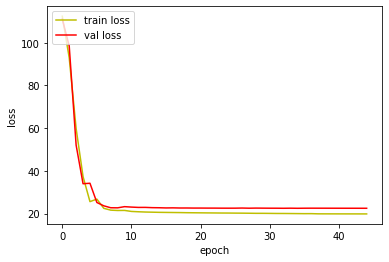

In [8]:
path_checkpoint = 'checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=10,verbose=0)


callback_reduce_lr = ReduceLROnPlateau(monitor='loss',
                                       factor=0.1,
                                       patience=1,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_reduce_lr]
hist = RNN.fit(trainX.values.reshape(-1,1,44),trainY, validation_data=(validX.values.reshape(-1,1,44), validY), 
                 epochs = 200, batch_size=30, callbacks=callbacks, verbose=1)

fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')

plt.show()

MAE
MAE_RNN =  3.6558964161352634


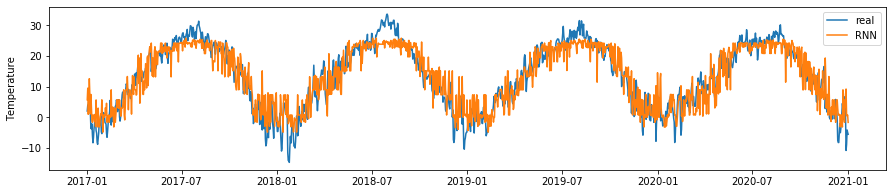

In [9]:
time = pd.to_datetime(test['일시'])

pred_RNN = RNN.predict(testX.values.reshape(-1,1,44)).reshape(-1,)


plt.figure(figsize = (15,3))
plt.plot(time,testY.reset_index()['Y'])
plt.plot(time,pred_RNN)

plt.ylabel('Temperature')
plt.legend(['real','RNN'])

print('MAE')
print('MAE_RNN = ',(((testY-pred_RNN.reshape(-1,))**2)**0.5).mean())

DNN으로 예측한 결과로 MAE를 계산했을 때, 2.x 정도 나왔다.  
RNN 결과는 3.x로 DNN보다 MAE도 낮고 그래프 상으로 보았을 때도 잘 예측하였다고 할 수 없다.  
여름과 겨울, 온도가 높아지고 낮아질 때 예측 정확도가 낮다.  
RNN을 잘못 쓰고 있는건 아닐까?

참고 글  
https://frhyme.github.io/machine-learning/simple_rnn/  
https://ratsgo.github.io/natural%20language%20processing/2017/03/09/rnnlstm/  
https://dreamgonfly.github.io/blog/understanding-rnn/

### RNN(Recurrent Neural Network)  
RNN은 시퀀스 데이터를 모델링 하기 위해 등장했다.  
위의 3개의 글을 보면 공통적으로 등장하는 그림이 있다.  
입력되는 데이터의 시퀀스 길이와 반환하는 시퀀스의 길이에 따라 RNN의 구조가 달라진다.  
이 구조를 모두 구현해보려한다.  
1) one to one  
2) one to many  
3) many to one  
4) many to many  
5) 또 다른 many to many  

1) one to one은 위에 구현되어 있는 RNN구조이다.  
먼저 그림과 같은 구조로 구현하기 위해 rnn층을 하나만 사용하여 구현하겠다.    

#### 1) one to one

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1, 44)]           0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 50)                4750      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 4,801
Trainable params: 4,801
Non-trainable params: 0
_________________________________________________________________
Train on 4749 samples, validate on 1461 samples
Epoch 1/200
4050/4749 [========================>.....] - ETA: 0s - loss: 193.3410
Epoch 00001: val_loss improved from inf to 143.71169, saving model to checkpoint.keras
4749/4749 [==============================] - 1s 160us/sample - loss: 184.2301 - val_loss: 143.7117
Epoch 2/200
3600/4749 [=====================>........] - ETA: 0s - loss

Epoch 29/200
4290/4749 [==========================>...] - ETA: 0s - loss: 16.1313
Epoch 00029: val_loss did not improve from 15.96393
4749/4749 [==============================] - 0s 44us/sample - loss: 16.0327 - val_loss: 16.1413
Epoch 30/200
4170/4749 [=========================>....] - ETA: 0s - loss: 16.0750
Epoch 00030: val_loss did not improve from 15.96393
4749/4749 [==============================] - 0s 44us/sample - loss: 15.8534 - val_loss: 16.0514
Epoch 31/200
4260/4749 [=========================>....] - ETA: 0s - loss: 15.8425
Epoch 00031: val_loss improved from 15.96393 to 15.88552, saving model to checkpoint.keras

Epoch 00031: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
4749/4749 [==============================] - 0s 45us/sample - loss: 15.8630 - val_loss: 15.8855
Epoch 32/200
4080/4749 [========================>.....] - ETA: 0s - loss: 15.4346
Epoch 00032: val_loss improved from 15.88552 to 15.86508, saving model to checkpoint.keras
4749/4749 [=====

Epoch 59/200
4200/4749 [=========================>....] - ETA: 0s - loss: 15.4532
Epoch 00059: val_loss did not improve from 15.76541
4749/4749 [==============================] - 0s 44us/sample - loss: 15.5560 - val_loss: 15.7655
Epoch 60/200
4140/4749 [=========================>....] - ETA: 0s - loss: 15.5503
Epoch 00060: val_loss did not improve from 15.76541

Epoch 00060: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.
4749/4749 [==============================] - 0s 45us/sample - loss: 15.5560 - val_loss: 15.7655
Epoch 61/200
4200/4749 [=========================>....] - ETA: 0s - loss: 15.4542
Epoch 00061: val_loss did not improve from 15.76541

Epoch 00061: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.
4749/4749 [==============================] - 0s 44us/sample - loss: 15.5560 - val_loss: 15.7655
Epoch 62/200
4170/4749 [=========================>....] - ETA: 0s - loss: 15.6101
Epoch 00062: val_loss did not improve from 15.76541

Epoch 00062: 

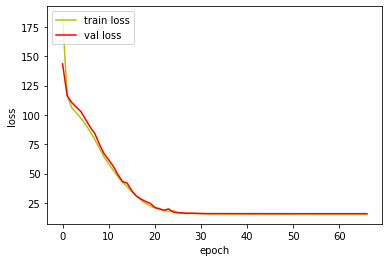

In [10]:
inputs_1 = tf.keras.Input(shape=(1,44))
rnn = tf.keras.layers.SimpleRNN(50, return_sequences=False)(inputs_1)
output = tf.keras.layers.Dense(1)(rnn)

RNN = tf.keras.Model(inputs=[inputs_1], outputs=output)

optimizer = tf.keras.optimizers.Adam(lr = 0.001)

RNN.compile(loss='mse', optimizer=optimizer)
RNN.summary()

path_checkpoint = 'checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=10,verbose=0)


callback_reduce_lr = ReduceLROnPlateau(monitor='loss',
                                       factor=0.1,
                                       patience=1,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_reduce_lr]
hist = RNN.fit(trainX.values.reshape(-1,1,44),trainY, validation_data=(validX.values.reshape(-1,1,44), validY), 
                 epochs = 200, batch_size=30, callbacks=callbacks, verbose=1)

fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')

plt.show()

MAE
MAE_RNN =  3.1039478896988446


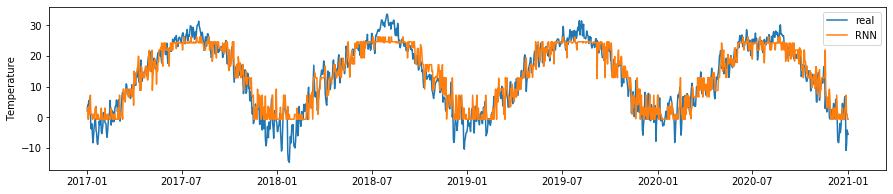

In [11]:
time = pd.to_datetime(test['일시'])

pred_RNN = RNN.predict(testX.values.reshape(-1,1,44)).reshape(-1,)


plt.figure(figsize = (15,3))
plt.plot(time,testY.reset_index()['Y'])
plt.plot(time,pred_RNN)

plt.ylabel('Temperature')
plt.legend(['real','RNN'])

print('MAE')
print('MAE_RNN = ',(((testY-pred_RNN.reshape(-1,))**2)**0.5).mean())

#### 2) one to many  
한장의 사진을 여러 단어로 이루어진 문장으로 학습하고 싶을 때 활용된다.  
입력과 출력 시퀀스 길이를 다르게 받는 모델을 설계하기 위해선 데이터 형태도 변형시켜야 한다  
모델 설계를 위해선 입력과 출력을 정의하여야 한다.  
one to many 형태의 rnn을 구현하기 위해 입력은 t시점의 기상 관측 데이터, 출력은 t+1,t+2,t+3 시점의 평균기온으로 정의한다.  

In [ ]:
# 위에서 설정해준 라벨 컬럼을 제거한다  
del data['Y']

In [ ]:
# 라벨값 설정
data['Y'] = data['평균기온(°C)'].shift(-2)
data = data.dropna()

# train, valid, test dataset 분리
train = data[data['일시']<'2013-01-01']
valid = data[data['일시']>='2013-01-01']
valid = valid[valid['일시']<'2017-01-01']
test = data[data['일시']>='2017-01-01']
print(' train set:',len(train),'개\n',
      'valid set:',len(valid),'개\n',
      'test set',len(test),'개')

# X와 Y분리
trainX,trainY = train.drop(['일시','Y'],axis=1), train['Y']
validX,validY = valid.drop(['일시','Y'],axis=1), valid['Y']
testX,testY = test.drop(['일시','Y'],axis=1), test['Y']

tf.keras.layers.SimpleRNN  레이어 설명을 보면 다음과 같다.  